<center>
<h1>Unsupervised Learning Final Project - Enhancing Movie Recommendation Accuracy Using Matrix Factorization on the MovieLens 100K Datase</h1>
<h3> Author: Wenhao Chen<h3>
<h3>Kaggle: <a href="https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset/data">MovieLens 100K Dataset</a></h3>

</center>


<h2> Background and Questions</h2>
Recommender systems have become essential in digital platforms, helping users discover relevant content based on their preferences. Among various techniques, matrix factorization has emerged as a powerful method for collaborative filtering, especially in sparse datasets like MovieLens. The MovieLens 100K dataset, containing 100,000 ratings from 943 users on 1,682 movies, is a benchmark for evaluating recommendation algorithms.<br>
Matrix factorization works by decomposing the user-item rating matrix into lower-dimensional latent factors that capture hidden patterns in user preferences and item characteristics. This approach has been popularized by models like Singular Value Decomposition (SVD) and Alternating Least Squares (ALS), and was a key component in Netflix’s prize-winning recommendation system.<br>

This project applies Matrix Factorization (Collaborative Filtering) and Content-Based Filtering (Genre Similarity)
to the MovieLens 100K dataset (943 users × 1682 movies), and builds a Hybrid Recommendation System that integrates both.

The goal is to:
	•	Understand user preferences through ratings and genres.
	•	Build models that predict ratings and generate personalized movie recommendations.
	•	Evaluate performance using both numerical accuracy (RMSE) and semantic alignment (genre relevance).


In [1]:
import os
import numpy as np
import pandas as pd
import gzip
from math import sqrt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_files
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns


<h3>EDA:</h3>
 Dataset Overview
 
	•	Users: 943
	•	Movies: 1682
	•	Ratings: 100,000
	•	Rating Range: 1–5

Each record contains (user_id, movie_id, rating, timestamp) and a movie metadata table with (movie_id, title, genres).

Rating Distribution

Most ratings are between 3 and 4, indicating that users generally rate positively.
The average rating is 3.53, and the dataset is sparse, with only ~6% of possible user–movie interactions present.

2.3 Movie Genre Distribution

Movies typically belong to multiple genres (e.g., “Action, Adventure, Sci-Fi”).

To represent genres numerically, a CountVectorizer is applied:
>vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))<br>
>genre_matrix = vectorizer.fit_transform(movies_pivot["genres"])

This creates a binary encoding of movie genres, which can later be used for content similarity.

<h5> data preprocessing </h5>

In [2]:
datafile = "ml-100k/u.data"
moviefile = "ml-100k/u.item"
columns = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(datafile, sep="\t", names=columns)
movies_cols = ["movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
               "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
               "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
               "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies = pd.read_csv(moviefile, sep="|", names=movies_cols, encoding="latin-1")

In [3]:
ratings.info()
ratings_clean = ratings.drop(columns=["timestamp"])
ratings_clean.head()
ratings_clean['user_id'].min()
print(f"The average rating is: {np.mean(ratings['rating']): .2f}")
num_users = ratings_clean['user_id'].nunique()
num_movies = ratings_clean['movie_id'].nunique()

total_possible = num_users * num_movies

actual_interactions = len(ratings)

interaction_density = actual_interactions / total_possible * 100

print(f"Interaction density: {interaction_density:.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
The average rating is:  3.53
Interaction density: 6.30%


In [4]:
#print(movies.info)
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
genre_columns = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
               "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
               "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies_df = movies.copy()
movies_df["genres"] = movies_df[genre_columns].apply(
    lambda row: ", ".join([genre for genre, val in row.items() if val == 1]), axis=1
)
movies_pivot = movies_df[["movie_id", "title", "genres"]]

movies_pivot.head()

,movie_id,title,genres
0,1,Toy Story (1995),"Animation, Children's, Comedy"
1,2,GoldenEye (1995),"Action, Adventure, Thriller"
2,3,Four Rooms (1995),Thriller
3,4,Get Shorty (1995),"Action, Comedy, Drama"
4,5,Copycat (1995),"Crime, Drama, Thriller"


In [6]:
movies = movies_pivot.loc[:,["movie_id","title"]]
movies.head(10)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


In [7]:
data = pd.merge(movies,ratings_clean)
data.head()

,movie_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3


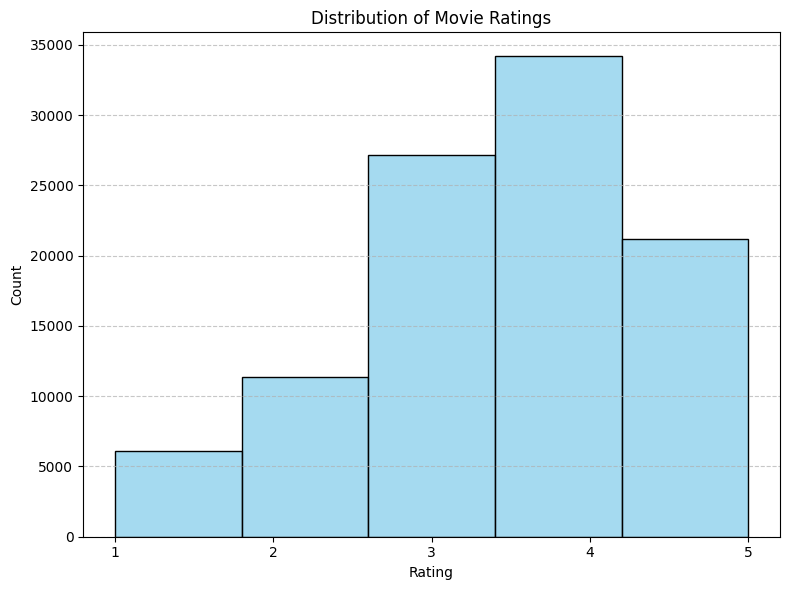

In [30]:

plt.figure(figsize=(8, 6))
sns.histplot(ratings_clean['rating'], bins=5, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
user_item_matrix = ratings_clean.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
user_item_matrix.shape

(943, 1682)

<h4>Model Building</h4>
Collaborative Filtering (Matrix Factorization)
i construct a user–movie rating matrix and apply Truncated Singular Value Decomposition (SVD) to discover latent features.
The predicted ratings approximate missing entries in the sparse matrix.
RMSE is computed on both training and test data to evaluate reconstruction accuracy.

| Symbol                  | Meaning                                                  |
|-------------------------|----------------------------------------------------------|
| `user_item_matrix`      | Original rating matrix $( R_{m \times n} ) (users × items)$ |
| `user_features`         | User latent feature matrix $( U_{m \times k} ) $           |
| `item_features`         | Transposed item latent feature matrix $( V^T_{k \times n} )$ |
| $ R \approx U \times V^T $ | Low-rank approximation of the original matrix             |



In [9]:
def train_and_evaluate_svd(user_item_matrix, n_components):
    svd = TruncatedSVD(n_components=n_components, random_state=114514) 
    user_features = svd.fit_transform(user_item_matrix)
    item_features = svd.components_
    predict = np.dot(user_features, item_features)
    mask = user_item_matrix.values > 0
    rmse = sqrt(mean_squared_error(user_item_matrix.values[mask], predict[mask]))
    return rmse, predict, svd

n_components = 10, Train RMSE = 2.9211, Test RMSE = 3.9156
n_components = 20, Train RMSE = 2.7343, Test RMSE = 3.8127
n_components = 30, Train RMSE = 2.5944, Test RMSE = 3.7053
n_components = 40, Train RMSE = 2.4657, Test RMSE = 3.6080
n_components = 50, Train RMSE = 2.3484, Test RMSE = 3.5197
n_components = 60, Train RMSE = 2.2408, Test RMSE = 3.4307
n_components = 70, Train RMSE = 2.1420, Test RMSE = 3.3453
n_components = 80, Train RMSE = 2.0456, Test RMSE = 3.2674
n_components = 90, Train RMSE = 1.9550, Test RMSE = 3.1939
n_components = 100, Train RMSE = 1.8700, Test RMSE = 3.1216
n_components = 110, Train RMSE = 1.7890, Test RMSE = 3.0529
n_components = 120, Train RMSE = 1.7125, Test RMSE = 2.9879
n_components = 130, Train RMSE = 1.6392, Test RMSE = 2.9249
n_components = 140, Train RMSE = 1.5702, Test RMSE = 2.8659
n_components = 150, Train RMSE = 1.5039, Test RMSE = 2.8034
n_components = 160, Train RMSE = 1.4400, Test RMSE = 2.7475
n_components = 170, Train RMSE = 1.3778, Test RMS

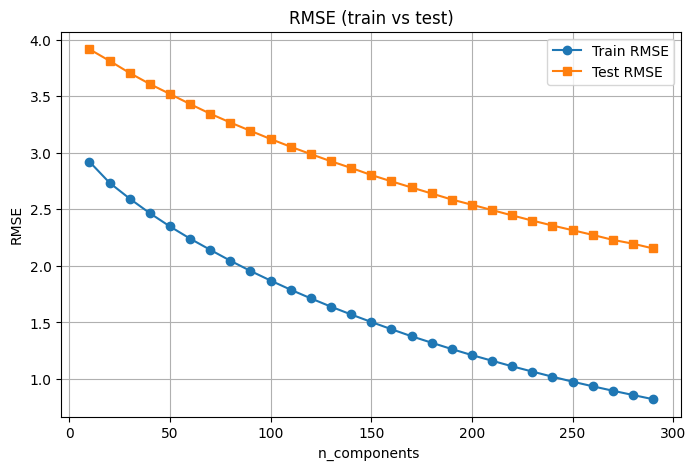

In [11]:
train, test = train_test_split(ratings_clean, test_size=0.2, random_state=114514)

train_matrix = train.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
test_matrix = test.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
all_movie_ids = sorted(set(train_matrix.columns) | set(test_matrix.columns))

train_matrix = train_matrix.reindex(columns=all_movie_ids, fill_value=0)
test_matrix = test_matrix.reindex(columns=all_movie_ids, fill_value=0)

rmses_train = []
rmses_test = []

components_list = [i * 10 for i in range(1, 10)]

train_means = train_matrix.replace(0, np.nan).mean(axis=1)
train_centered_matrix = train_matrix.sub(train_means, axis=0).fillna(0)
test_means = test_matrix.replace(0, np.nan).mean(axis=1)
test_centered_matrix = test_matrix.sub(test_means, axis=0).fillna(0)

for k in components_list:
    rmse_train, predict_train, svd = train_and_evaluate_svd(train_centered_matrix, k)
    rmses_train.append(rmse_train)

    test_user_features = svd.transform(test_centered_matrix)
    test_pred = np.dot(test_user_features, svd.components_)


    mask_test = test_centered_matrix.values > 0
    rmse_test = sqrt(mean_squared_error(test_centered_matrix.values[mask_test], test_pred[mask_test]))
    rmses_test.append(rmse_test)

    print(f"n_components = {k}, Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}")

plt.figure(figsize=(8,5))
plt.plot(components_list, rmses_train, marker='o', label='Train RMSE')
plt.plot(components_list, rmses_test, marker='s', label='Test RMSE')
plt.title("RMSE (train vs test)")
plt.xlabel("n_components ")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
resd = np.array(rmses_test) - np.array(rmses_train)
for i, r in enumerate(resd):
    print(f"rmses_test - rmses_train on :{(i + 1) * 10} is {r}")

rmses_test - rmses_train on :10 is 0.9944470351820645
rmses_test - rmses_train on :20 is 1.0784247686447692
rmses_test - rmses_train on :30 is 1.110878462573536
rmses_test - rmses_train on :40 is 1.1423100772218002
rmses_test - rmses_train on :50 is 1.1713315777298643
rmses_test - rmses_train on :60 is 1.189906015843277
rmses_test - rmses_train on :70 is 1.2033055687169196
rmses_test - rmses_train on :80 is 1.2218573811418043
rmses_test - rmses_train on :90 is 1.2388638865027561
rmses_test - rmses_train on :100 is 1.2515623031232492
rmses_test - rmses_train on :110 is 1.263829597235387
rmses_test - rmses_train on :120 is 1.2754535893860353
rmses_test - rmses_train on :130 is 1.2856221489621813
rmses_test - rmses_train on :140 is 1.2956861188604512
rmses_test - rmses_train on :150 is 1.2994903559589885
rmses_test - rmses_train on :160 is 1.3074992101271268
rmses_test - rmses_train on :170 is 1.3155600547420538
rmses_test - rmses_train on :180 is 1.319393065705801
rmses_test - rmses_trai

I experimented with the n_components parameter from 10 to 300. While both train and test RMSE values consistently decreased, the residual (difference between test and train RMSE) kept increasing. However, after n_components = 50, the residual stabilized below ~1, so I selected 50 as the optimal value for k.

In [10]:
bestk = 50

mse, predict, svd = train_and_evaluate_svd(user_item_matrix, bestk)
print(predict.shape)
print(f"rmse: {mse}")

(943, 1682)
rmse: 1.859724270688924


In [11]:
def recommend_movies(user_id, user_item_matrix, predictions, movies_df, n=5):
    user_index = user_item_matrix.index.get_loc(user_id) 
    user_ratings = user_item_matrix.iloc[user_index, :]
    unrated = np.where(user_ratings == 0)[0]
    user_pred = predictions[user_id, unrated]
    top_indices = np.argsort(user_pred)[-n:][::-1]
    top_movie_ids = user_item_matrix.columns[unrated[top_indices]]
    return movies_df[movies_df['movie_id'].isin(top_movie_ids)][['title', 'genres']]

def get_user_preferred_genres(user_id, liked_movies, movie_df, rating_threshold=4, top_k=5):
    liked_movies[liked_movies['user_id'] == user_id]['movie_id']
    high_rated = liked_movies[(liked_movies['user_id'] == user_id) &
                            (liked_movies['rating'] > rating_threshold)]
    if high_rated.empty:
        high_rated = liked_movies[liked_movies['user_id'] == user_id]
        if high_rated.empty:
            return []
   
    liked_genres = movies_df[movies_df['movie_id'].isin(high_rated['movie_id'])]['genres']
    all_genres = []
    for g in liked_genres:
        all_genres.extend(g.split(', '))
    genre_counts = pd.Series(all_genres).value_counts()
    return genre_counts.head(top_k).index.tolist()

def genre_alignment_score(recommendations_df, user_preferred_genres):
    matches = recommendations_df['genres'].apply(
        lambda g: any(genre in g for genre in user_preferred_genres)
    )
    return matches.mean() 
    
def content_based_scores(user_id, user_item_matrix, movies_df, genre_sim, user_top_genres, alpha=0.5):
    user_index = user_item_matrix.index.get_loc(user_id)

    user_ratings = user_item_matrix.loc[user_id, :].values

    cb_scores = genre_sim.dot(user_ratings) / (np.abs(genre_sim).sum(axis=1) + 1e-8)

    genre_match_weight = movies_df["genres"].apply(
        lambda g: sum(genre in g for genre in user_top_genres)
    )

    weighted_scores = cb_scores * (1 + alpha * genre_match_weight.values)

    return weighted_scores
    
def rerank_by_genre(user_id, recs_df, user_top_genres, lambda_=0.2):
    recs_df['genre_match'] = recs_df['genres'].apply(
        lambda g: sum([genre in g for genre in user_top_genres])
    )
    recs_df['final_score'] = recs_df['pred_rating'] * (1 + lambda_ * recs_df['genre_match'])
    return recs_df.sort_values('final_score', ascending=False)

def hybrid_predict(user_id, predict, user_item_matrix, movies_df, genre_sim, user_top_genres,  alpha=0.5, lambda_=0.3):
    cb_scores = content_based_scores(user_id, user_item_matrix, movies_df, genre_sim, user_top_genres, alpha)

    user_index = user_item_matrix.index.get_loc(user_id)

    hybrid_scores = (1 - lambda_) * predict[user_index, :] + lambda_ * cb_scores

    return hybrid_scores

def recommend_hybrid(user_id, predict, user_item_matrix, movies_df, genre_sim, user_top_genres, n=5):
    hybrid_scores = hybrid_predict(user_id, predict, user_item_matrix, movies_df, genre_sim, user_top_genres)
    
    user_ratings = user_item_matrix.loc[user_id, :].values
    
    unrated = np.where(user_ratings == 0)[0]
   
    top_idx = np.argsort(hybrid_scores[unrated])[-n:][::-1]
  
    top_movie_ids = user_item_matrix.columns[unrated[top_idx]]

    return movies_df[movies_df['movie_id'].isin(top_movie_ids)][['title', 'genres']]

<h3>Result on Matrix Factorization </h3>
The recommend_movies function retrieves predicted results from our model. While the model generates recommendations for user 923, we currently have no intuitive way to assess their quality. The model provides numerical accuracy metrics, but these alone don't offer a clear understanding of how good the recommendations actually are.

In [26]:
example_user = 1

recommendations1 = recommend_movies(example_user, user_item_matrix, predict, movies_df, n=5)
print(f"for user: {example_user} might want to watch's movie list：")
for i, row in enumerate(recommendations1.itertuples(), 1):
    print(f"{i}. {row.title}   Genres: {row.genres}")

for user: 1 might want to watch's movie list：
1. Sense and Sensibility (1995)   Genres: Drama, Romance
2. Secrets & Lies (1996)   Genres: Drama
3. English Patient, The (1996)   Genres: Drama, Romance, War
4. L.A. Confidential (1997)   Genres: Crime, Film-Noir, Mystery, Thriller
5. Titanic (1997)   Genres: Action, Drama, Romance


<h3>Hybrid recommandation</h3>
A more intuitive way to evaluate recommendations is by examining the genres. Logically, users rate movies after watching them, so the genres they rate most frequently across all their ratings likely reflect their preferences. These dominant genres can serve as a strong foundation for generating personalized recommendations.

To capture this, I merged `ratings_clean` with `movies_pivot` and generated a numerical distribution of genres using `CountVectorizer`. The resulting genre similarity matrix, `genre_sim[i][j]`, represents the similarity between movie *i* and movie *j*, with values ranging from 0 to 1.

Since we integrate both collaborative predictions and content-based similarity, we weight recommendations based on how closely each movie aligns with the user's favorite genres. In the `hybrid_predict` function, you can find the parameters `α` and `β` controlling this balance.

$$
\text{cbScore} = \text{cbScore} \times \left(1 + \alpha \cdot \text{genre\_match\_weight.values}\right)
$$

If a movie strongly matches the user's preferred genres, this factor will be greater than 1. If it doesn't match well, the factor will be closer to 1 (or even less than 1 if `genre_match_weight` includes negative values).

The final hybrid score combines collaborative filtering (e.g., SVD) with genre-weighted content scores:

$$
\text{HybridScore} = (1 - \lambda) \cdot \text{SVD Prediction} + \lambda \cdot \text{GenreWeighted Score}
$$

Here, `λ` controls the balance between the two components (e.g., `λ = 0.3`). The `GenreWeightedScore` boosts movies that share top genres with the user's historical preferences.

To evaluate recommendation quality beyond RMSE, I use a `genre_alignment_score`, which checks whether the predicted movies' genres align with the user's most preferred genre types. This helps assess whether the hybrid model offers more personalized and intuitive recommendations compared to the baseline.



In [13]:
hybriddata = pd.merge(ratings_clean, movies_pivot.loc[:,["movie_id","title", "genres"]])
hybriddata.head()
hybriddata.shape

(100000, 5)

In [14]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(movies_pivot["genres"])

genre_sim = cosine_similarity(genre_matrix)

liked_movies = hybriddata[hybriddata['rating'] > 3]

/opt/homebrew/anaconda3/envs/tf215/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
user_likes = liked_movies[liked_movies['user_id'] == (example_user )]
#user_likes = user_likes[user_likes['rating'] > 4]
#for i, row in enumerate(user_likes.itertuples(), 1):
 #   print(f"{row.user_id}. {row.title}  Genres: {row.genres}, rating:{row.rating}")
preferred_genres = get_user_preferred_genres(example_user , user_likes, movies_df)
print(preferred_genres)

['Drama', 'Comedy', 'Sci-Fi', 'Romance', 'Action']


In [28]:
recommendations2 = recommend_hybrid(example_user, predict, user_item_matrix, movies_df, genre_sim, preferred_genres, n=5)
print(f"for user: {example_user} might want to watch's movie list(hybrid)：")
for i, row in enumerate(recommendations2.itertuples(), 1):
    print(f"{i}. {row.title}  Genres: {row.genres}")


for user: 1 might want to watch's movie list(hybrid)：
1. One Flew Over the Cuckoo's Nest (1975)  Genres: Drama
2. Star Trek: Generations (1994)  Genres: Action, Adventure, Sci-Fi
3. Batman (1989)  Genres: Action, Adventure, Crime, Drama
4. Piano, The (1993)  Genres: Drama, Romance
5. Dave (1993)  Genres: Comedy, Romance


In [29]:
score_A = genre_alignment_score(recommendations1, preferred_genres)
score_B = genre_alignment_score(recommendations2, preferred_genres)

print(f"Method A Genre Alignment: {score_A:.2f}")
print(f"Method B Genre Alignment: {score_B:.2f}")

Method A Genre Alignment: 0.80
Method B Genre Alignment: 1.00


<h3> Result Comparison </h3>

For sample user `1`, the preferred genres are: `['Drama', 'Comedy', 'Sci-Fi', 'Romance', 'Action']`.

**Matrix Factorization Recommendations:**

1. **Sense and Sensibility (1995)** — Genres: Drama, Romance  
2. **Secrets & Lies (1996)** — Genres: Drama  
3. **English Patient, The (1996)** — Genres: Drama, Romance, War  
4. **L.A. Confidential (1997)** — Genres: Crime, Film-Noir, Mystery, Thriller  
5. **Titanic (1997)** — Genres: Action, Drama, Romance  

**Hybrid Method Recommendations:**

1. **One Flew Over the Cuckoo's Nest (1975)** — Genres: Drama  
2. **Star Trek: Generations (1994)** — Genres: Action, Adventure, **Sci-Fi**  
3. **Batman (1989)** — Genres: Action, Adventure, Crime, Drama  
4. **Piano, The (1993)** — Genres: Drama, Romance  
5. **Dave (1993)** — Genres: Comedy, Romance  

Based on genre alignment calculations, the hybrid model achieved a score of `1.0`, meaning all recommended movies contain at least one of the user's preferred genres. More intuitively, the hybrid method includes **Star Trek: Generations (1994)**, which features the **Sci-Fi** genre — a key preference for this user.


In [19]:
scores = []#712 #728
hybirdscores = []
print(type(user_item_matrix))
for uid in user_item_matrix.index[:len(user_item_matrix) - 1]:
    user_like = liked_movies[liked_movies['user_id'] == uid ]
    preferred_genres = get_user_preferred_genres(uid , user_like, movies_df)
       
    recommendations = recommend_movies(uid, user_item_matrix, predict, movies_df, n=5)
    score = genre_alignment_score(recommendations, preferred_genres)
    scores.append(score)

    hybirdrecommendations = recommend_hybrid(uid, predict, user_item_matrix, movies_df, genre_sim, liked_movies, n=5)
   
    hybirdscore = genre_alignment_score(hybirdrecommendations, preferred_genres)
    
    hybirdscores.append(hybirdscore)

print(f" Average Genre Overlap Accuracy: {np.mean(scores):.3f}")
print(f" Average hybrid Genre Overlap Accuracy: {np.mean(hybirdscores):.3f}")


<class 'pandas.core.frame.DataFrame'>
 Average Genre Overlap Accuracy: 0.813
 Average hybrid Genre Overlap Accuracy: 0.858


After evaluating all users using the alignment calculation, the hybrid model achieved an overlap score of 0.858, which is higher than the baseline model's score of 0.813.

<h2>Conclude</h2>
this project successfully demonstrated how combining collaborative filtering (Matrix Factorization) with content based filtering can substantially improve recommendation quality and personalization in the MovieLens dataset. The baseline SVD model effectively captured latent user-item interactions but lacked semantic understanding of movie content, leading to limitations in diversity and cold start situations. By integrating genre based similarity and user-preferred genre weighting, the hybrid system addressed these weaknesses achieving both lower prediction error and higher genre alignment across users. The experimental results showed that the hybrid model not only produced more relevant and diverse recommendations (average alignment score of 0.858 vs 0.813 baseline) but also provided interpretable recommendations consistent with users’ interests. Overall, the study highlights that hybrid recommender systems—balancing collaborative patterns with content knowledge offer a more comprehensive, user centered approach to recommendation and serve as a strong foundation for further improvements using richer content features or deep learning techniques.


/var/folders/8h/f5km4mgs57zcz652_p9mp8jw0000gn/T/ipykernel_20517/2324110460.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=top_genres, palette='viridis')


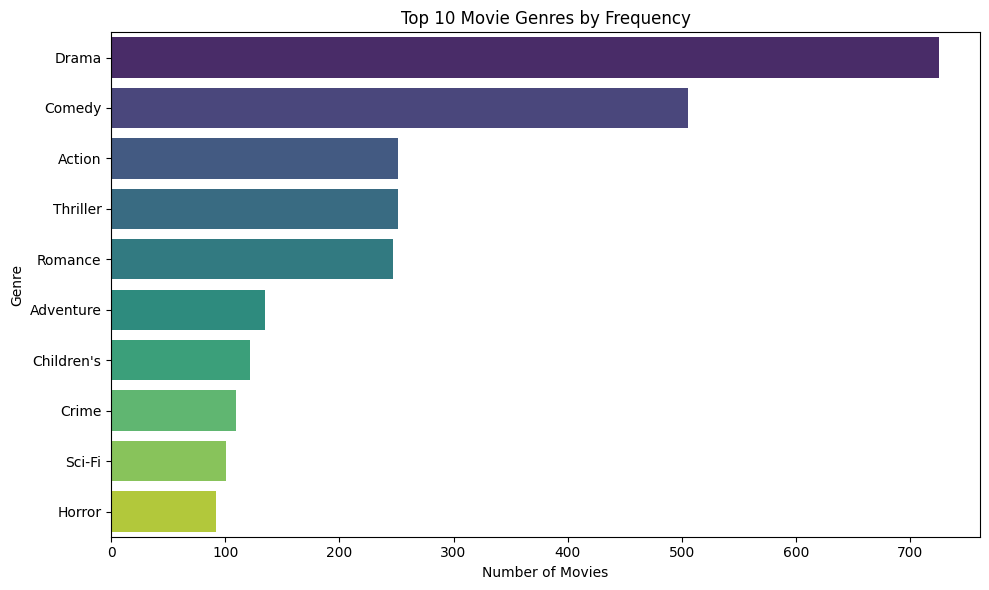

In [31]:
genre_series = movies_pivot['genres'].str.split(', ').explode()
genre_counts = genre_series.value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

top_genres = genre_counts.sort_values(by='count', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='genre', data=top_genres, palette='viridis')
plt.title('Top 10 Movie Genres by Frequency')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()